# HW 2 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

Get the time series for the following cryptocurrencies from cryptowat.ch starting from 2021-11-22, hourly data:
1. ETH 
2. SOL
3. AVAX
4. USDT
5. FLOW

In [2]:
def get_data(token):
    if token == 'FLOW':
        exchange = 'kraken'
    else:
        exchange = 'coinbase-pro'
    result = requests.get(f'https://api.cryptowat.ch/markets/{exchange}/{token}usd/ohlc',
                         params={'periods': '3600',
                                 'after': str(int(pd.Timestamp('2021-11-22').timestamp()))
                                },
                          timeout=10
                         )
    df = pd.DataFrame(result.json()['result']['3600'],
                     columns=['ts','open','high','low','close','volume','volumeUSD'])
    df['ts'] = pd.to_datetime(df.ts, unit='s')
    df['token'] = token
    
    return df

In [3]:
tokens = ['ETH','SOL','AVAX','USDT','FLOW']

dfs = [get_data(token) for token in tokens]

df = pd.concat(dfs)

In [4]:
df.head()

,ts,open,high,low,close,volume,volumeUSD,token
0,2021-11-22 00:00:00,4317.98,4342.24,4246.07,4262.99,7262.562789,3.123077e+07,ETH
1,2021-11-22 01:00:00,4263.04,4270.34,4212.45,4234.37,8437.946084,3.574586e+07,ETH
2,2021-11-22 02:00:00,4234.87,4246.72,4171.17,4217.89,9259.725370,3.895639e+07,ETH
3,2021-11-22 03:00:00,4217.88,4223.48,4163.58,4193.47,9259.899519,3.882032e+07,ETH
4,2021-11-22 04:00:00,4192.95,4213.59,4147.00,4168.35,7934.546906,3.315476e+07,ETH


Get the total USD volume traded for each token in a dataframe, sorted from highest volume to lowest volume

In [5]:
df.groupby('token').agg({'volumeUSD':'sum'}).sort_values(by='volumeUSD',ascending=False)

,volumeUSD
token,
ETH,2.618366e+10
SOL,8.553175e+09
AVAX,4.763405e+09
USDT,2.361627e+09
FLOW,1.006481e+08


Add a column that calculates the close price ratio between ETH and SOL for each house (i.e. close price of ETH / close price of SOL for each period)


In [6]:
ETH_df, SOL_df = dfs[0], dfs[1]
ETH2SOL_ratio = pd.Series(ETH_df.set_index('ts').close / SOL_df.set_index('ts').close,name='ETH2SOL_ratio')

df = df.join(ETH2SOL_ratio, on='ts')
df.head()

,ts,open,high,low,close,volume,volumeUSD,token,ETH2SOL_ratio
0,2021-11-22 00:00:00,4317.98,4342.24,4246.07,4262.99,7262.562789,3.123077e+07,ETH,18.471694
1,2021-11-22 01:00:00,4263.04,4270.34,4212.45,4234.37,8437.946084,3.574586e+07,ETH,18.736150
2,2021-11-22 02:00:00,4234.87,4246.72,4171.17,4217.89,9259.725370,3.895639e+07,ETH,18.577985
3,2021-11-22 03:00:00,4217.88,4223.48,4163.58,4193.47,9259.899519,3.882032e+07,ETH,18.794937
4,2021-11-22 04:00:00,4192.95,4213.59,4147.00,4168.35,7934.546906,3.315476e+07,ETH,18.891059


Change the name of the volume and volumeUSD columns to volumeBase and volumeTerm


In [7]:
df = df.rename(columns = {'volume':'volumeBase','volumeUSD':'volumeTerm'})
df

,ts,open,high,low,close,volumeBase,volumeTerm,token,ETH2SOL_ratio
0,2021-11-22 00:00:00,4317.980,4342.240,4246.070,4262.990,7262.562789,3.123077e+07,ETH,18.471694
1,2021-11-22 01:00:00,4263.040,4270.340,4212.450,4234.370,8437.946084,3.574586e+07,ETH,18.736150
2,2021-11-22 02:00:00,4234.870,4246.720,4171.170,4217.890,9259.725370,3.895639e+07,ETH,18.577985
3,2021-11-22 03:00:00,4217.880,4223.480,4163.580,4193.470,9259.899519,3.882032e+07,ETH,18.794937
4,2021-11-22 04:00:00,4192.950,4213.590,4147.000,4168.350,7934.546906,3.315476e+07,ETH,18.891059
...,...,...,...,...,...,...,...,...,...
709,2021-12-21 13:00:00,8.314,8.430,8.314,8.320,67534.936097,5.657011e+05,FLOW,22.310442
710,2021-12-21 14:00:00,8.332,8.353,8.320,8.353,6606.179474,5.509017e+04,FLOW,22.092592
711,2021-12-21 15:00:00,8.366,8.366,8.303,8.312,16645.955808,1.384929e+05,FLOW,22.343111
712,2021-12-21 16:00:00,8.316,8.316,8.227,8.253,3204.807564,2.642048e+04,FLOW,22.417038


create a fat table indexed by the timestamp, and each column is the close price of each token (i.e. this should be a table of 200 rows and 5 columns)

calculate the hour by hour log return of the close price of each token (return is calculated by np.log(price_t / price_{t-1}))

[Stretch] calculate the correlation of the tokens using the table above

[Stretch] visualize the correlation in a matplpotlib plot

In [8]:
close_df = pd.concat([token_df.set_index('ts')[['close']].rename(columns={'close':token}) for token, token_df in zip(tokens, dfs)], axis=1)
close_df.head()

,ETH,SOL,AVAX,USDT,FLOW
ts,,,,,
2021-11-22 00:00:00,4262.99,230.785,128.67,1.0012,14.150
2021-11-22 01:00:00,4234.37,226.000,134.85,1.0013,13.621
2021-11-22 02:00:00,4217.89,227.037,132.54,1.0012,13.753
2021-11-22 03:00:00,4193.47,223.117,133.38,1.0011,13.652
2021-11-22 04:00:00,4168.35,220.652,136.29,1.0009,13.581


calculate the hour by hour log return of the close price of each token (return is calculated by np.log(price_t / price_{t-1}))

calculate the correlation of the tokens using the table above


In [9]:
ret_df = np.log(close_df.iloc[1:]/close_df.iloc[:-1].values)
ret_df.corr()

,ETH,SOL,AVAX,USDT,FLOW
ETH,1.000000,0.761399,0.659316,-0.084683,0.580218
SOL,0.761399,1.000000,0.648454,0.104318,0.478545
AVAX,0.659316,0.648454,1.000000,0.016763,0.405687
USDT,-0.084683,0.104318,0.016763,1.000000,-0.173974
FLOW,0.580218,0.478545,0.405687,-0.173974,1.000000


Visualize the correlation in a matplpotlib plot

<Figure size 432x288 with 0 Axes>

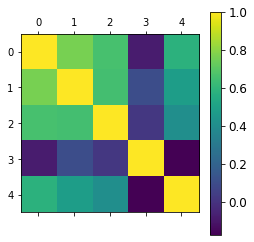

In [10]:
fig = plt.figure()
plt.matshow(ret_df.corr())
cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)
plt.show()